In [1]:
# import library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [97]:
!pip install xgboost

     ------------------------------------ 125.4/125.4 MB 978.3 kB/s eta 0:00:00


In [125]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [126]:
# determine categorical and numerical features
NumCols = [f for f in train.columns if train.dtypes[f] != 'object']
NumCols.remove('SalePrice')
NumCols.remove('Id')
CatCols = [f for f in train.columns if train.dtypes[f] == 'object']

In [127]:
train.shape

(1460, 81)

In [128]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

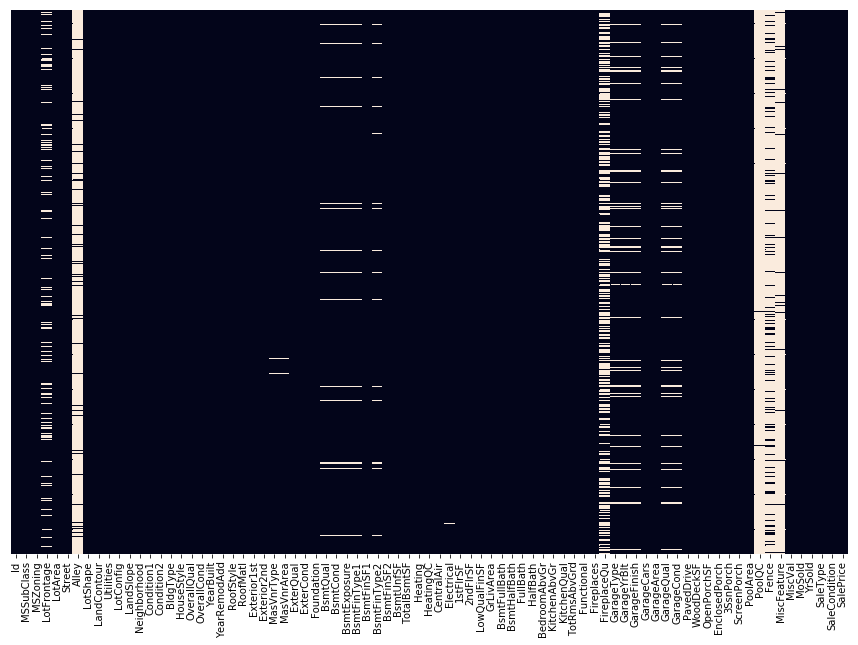

In [129]:
# finding NA value and assign its value based on central tedency of the feature
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(train.isnull(),yticklabels=False, cbar=False)

In [130]:
# get all features that have null value
null_feature = [x for x in train.columns if train[x].isnull().any() == True] 
null_feature

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [131]:
# find each dtype of its feature
train[null_feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1452 non-null   object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

Categorical feature contains the most null values is because it doesnt have that particular feature eg. lack of pool, fence etc.

In [132]:
# fill null value in categorical as 'missing' indicates it doesnt have that feature
for feature in CatCols:
    train[feature] = train[feature].astype('category')
    if train[feature].isnull().any():
        train[feature] = train[feature].cat.add_categories(['MISSING'])
        train[feature] = train[feature].fillna('MISSING')

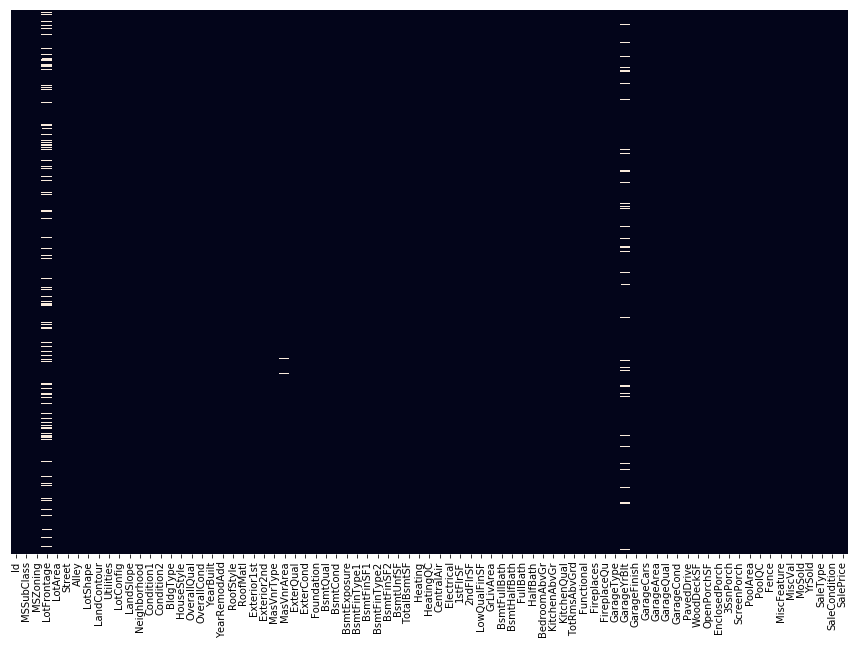

In [133]:
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(train.isnull(),yticklabels=False, cbar=False)

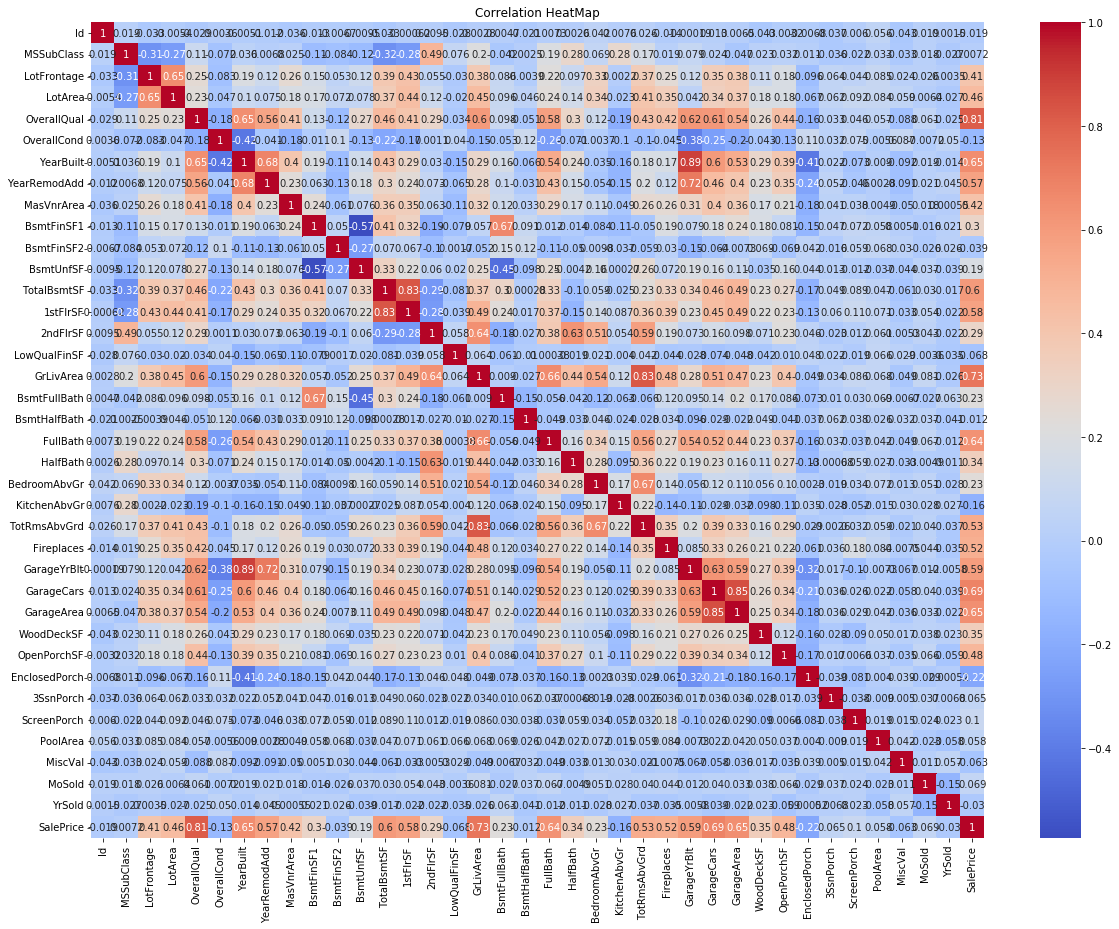

In [134]:
plt.figure(figsize=(20,15))
sns.heatmap(train.corr('spearman'), cmap='coolwarm', annot=True, square=False)
plt.title('Correlation HeatMap');

We can see that Garage Year Built (GarageYrBlt) is high positive correlation with YearBuilt. We can say that the garage is built at the same year with the house.

In [135]:
# fill missing value in GarageYrBlt
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['YearBuilt'])

In [136]:
missing = train.isnull().sum() > 0
missing = missing[missing > 0]
missing

LotFrontage    True
MasVnrArea     True
dtype: bool

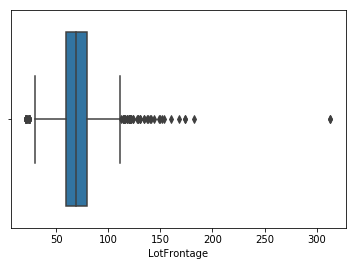

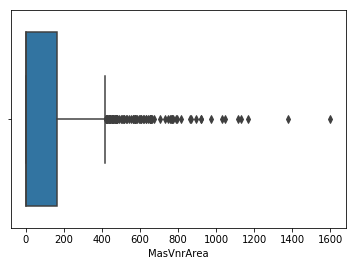

In [137]:
# draw boxplot to find any outlier for continuous features
for feature in ['LotFrontage', 'MasVnrArea']:
    plt.figure()
    sns.boxplot(train[feature])

We fill the remaining missing feature with median instead of mean because of lots of outlier

In [138]:
# fill missing values with its median since there is outlier
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].median())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].median())

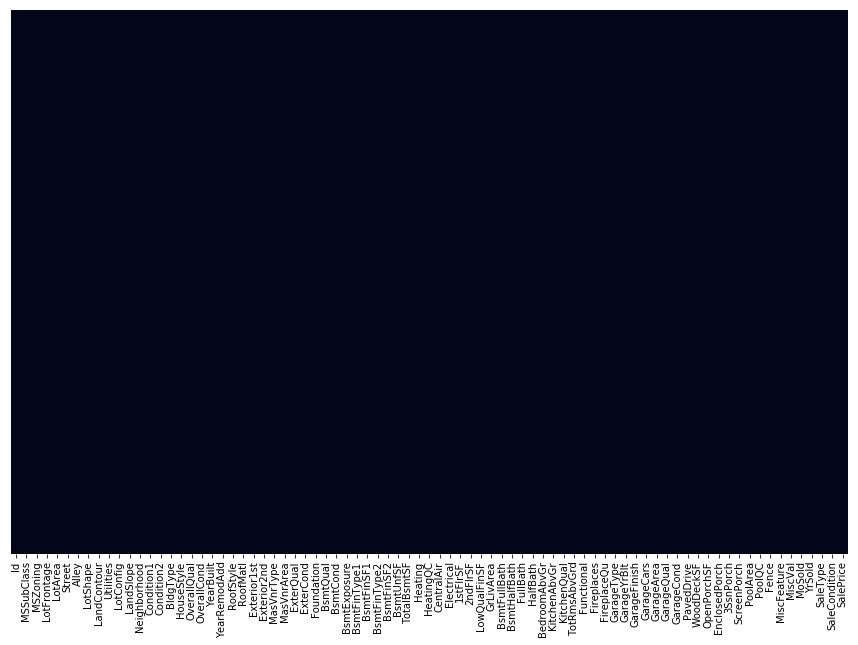

In [139]:
# double check for any missing value
f, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(train.isnull(),yticklabels=False, cbar=False)

In [140]:
train.shape

(1460, 81)

In [141]:
len(CatCols)

43

In [142]:
# get numerical columns
len(NumCols)

36

Now handling test dataset

In [143]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [144]:
# fill null value in categorical as 'missing' indicates it doesnt have that feature
for feature in CatCols:
    test[feature] = test[feature].astype('category')
    if test[feature].isnull().any():
        test[feature] = test[feature].cat.add_categories(['MISSING'])
        test[feature] = test[feature].fillna('MISSING')

In [145]:
# fill missing value in GarageYrBlt
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(test['YearBuilt'])

In [146]:
# get all features that have null value
null_feature = [x for x in test.columns if test[x].isnull().any() == True] 
null_feature

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea']

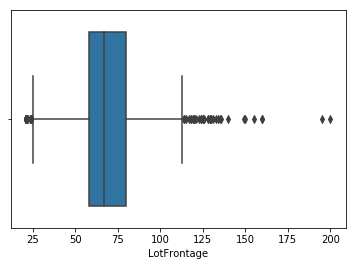

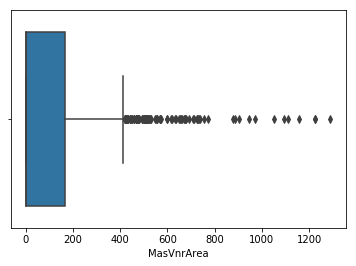

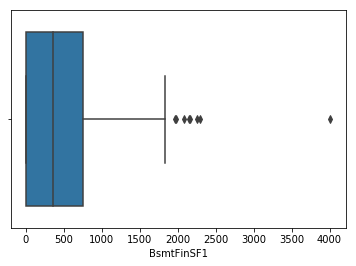

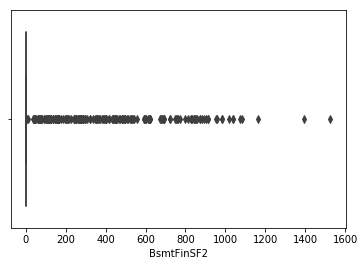

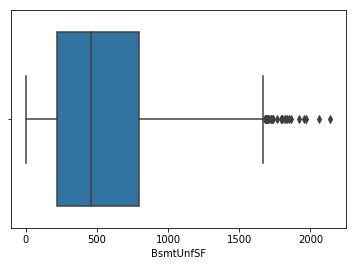

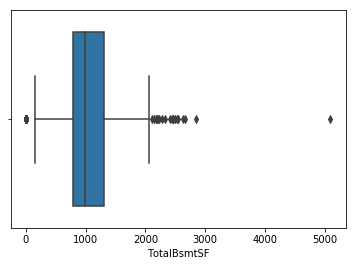

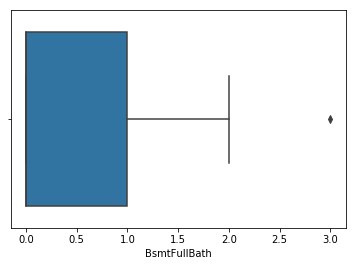

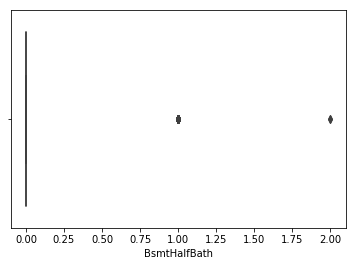

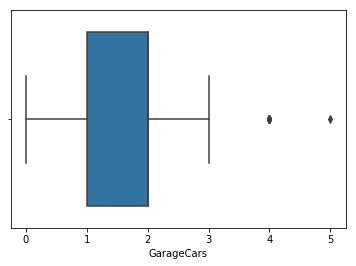

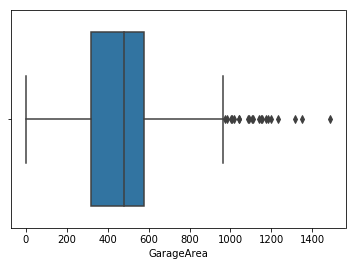

In [147]:
# draw boxplot to find any outlier for null features
for feature in null_feature:
    plt.figure()
    sns.boxplot(test[feature])

In [148]:
# fill missing values with its median since there is outlier
for feature in null_feature:
    test[feature] = test[feature].fillna(test[feature].median())

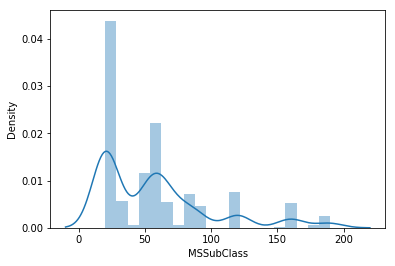

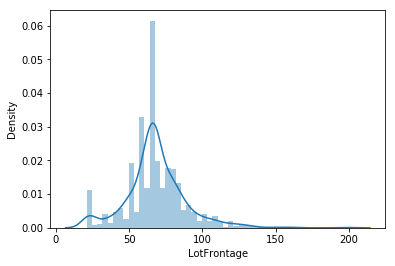

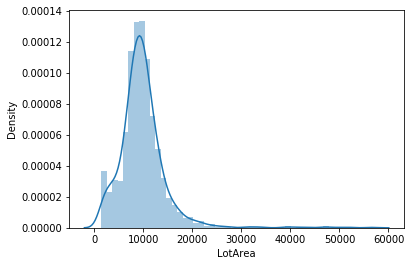

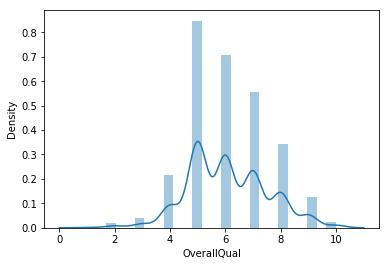

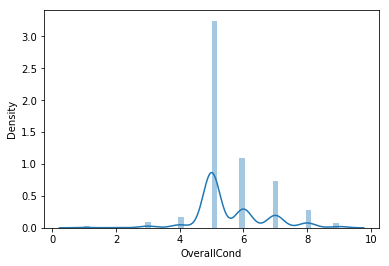

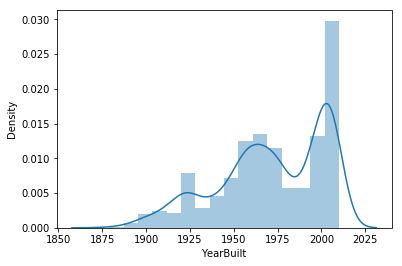

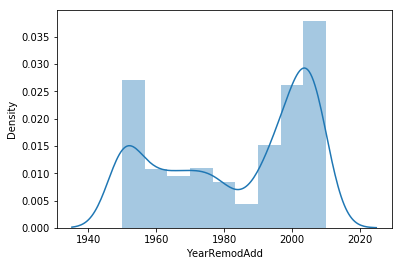

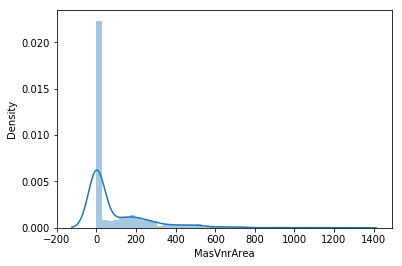

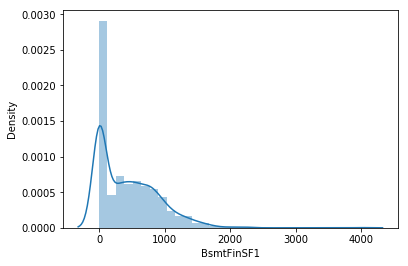

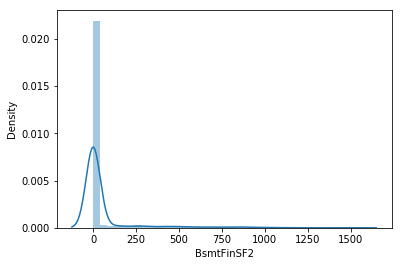

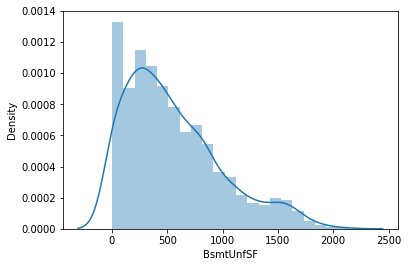

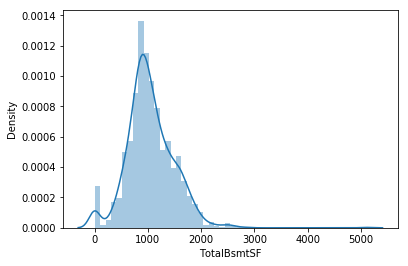

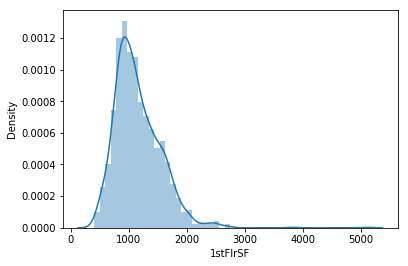

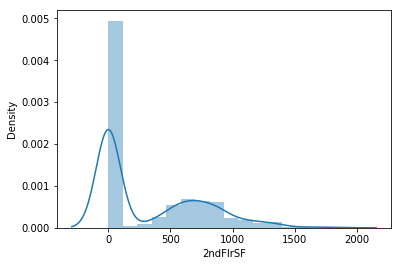

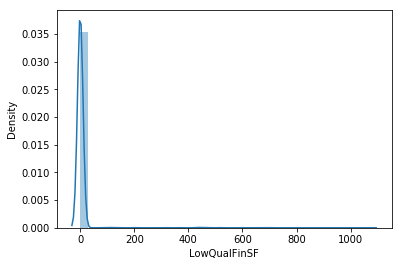

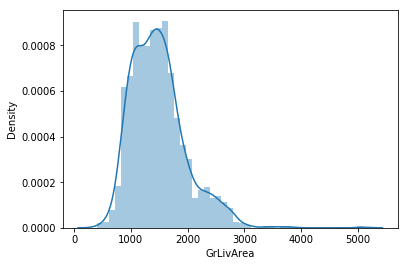

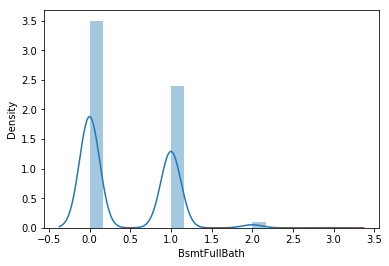

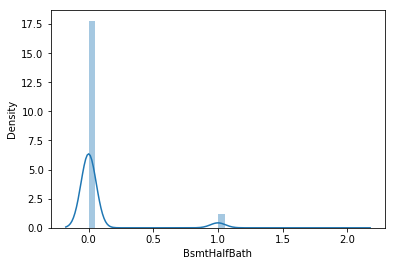

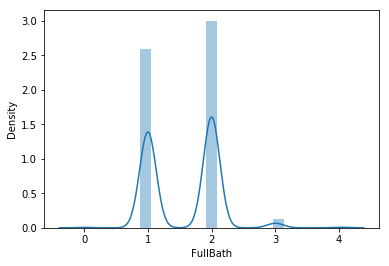

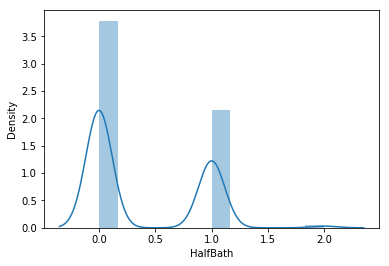

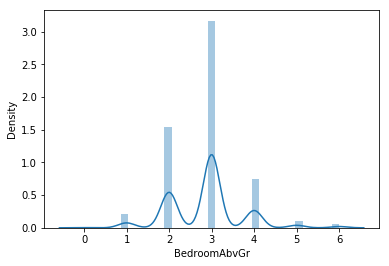

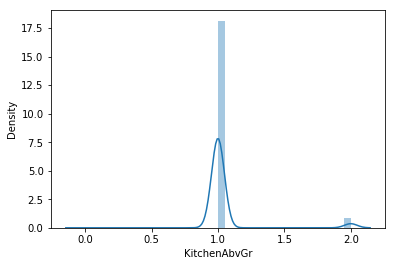

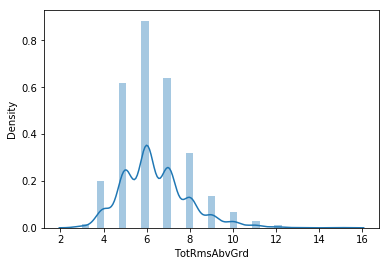

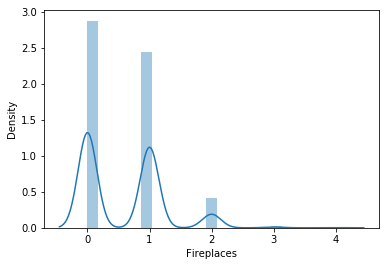

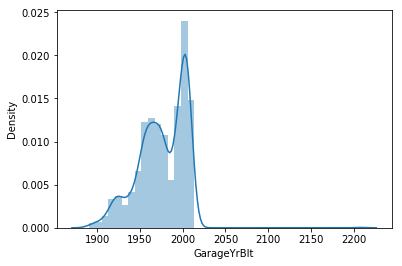

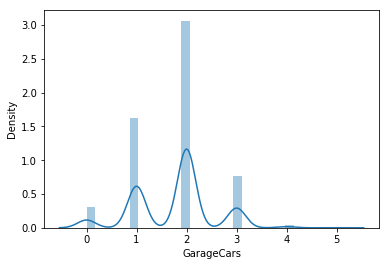

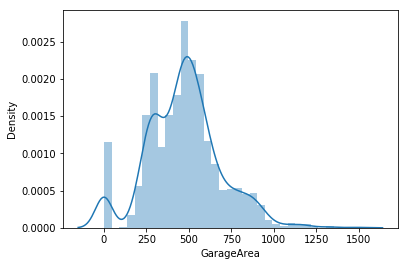

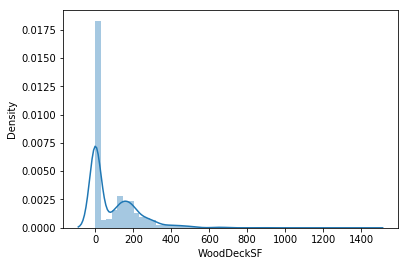

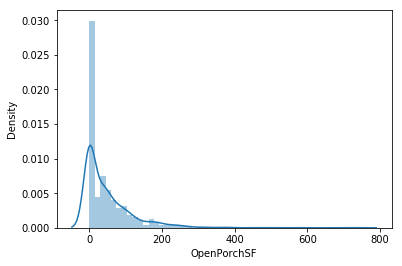

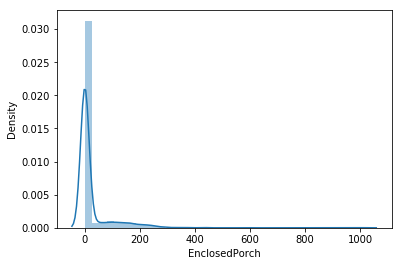

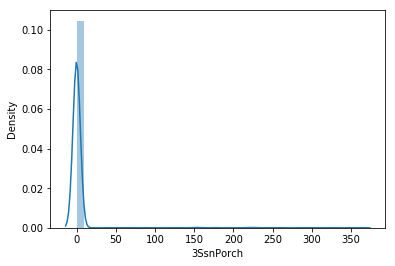

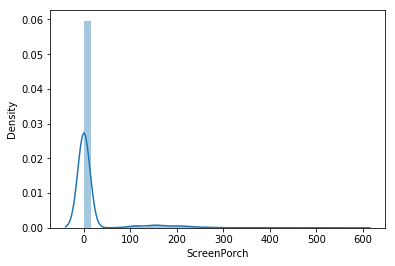

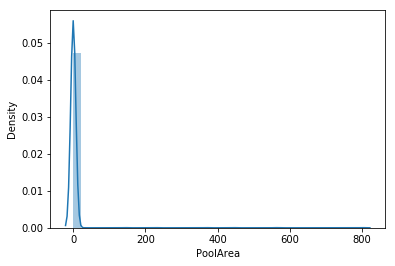

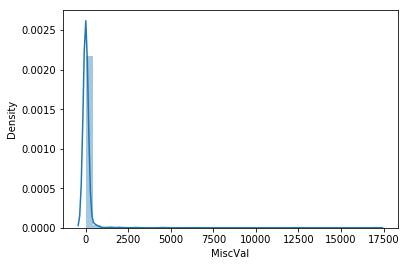

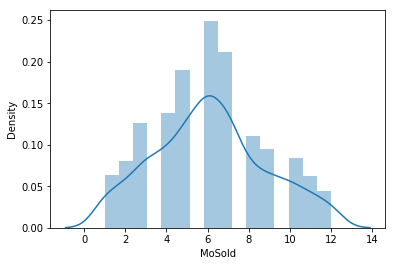

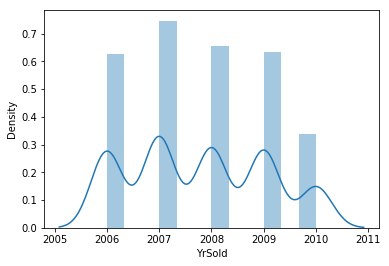

In [149]:
for feature in NumCols:
    plt.figure()
    sns.distplot(test[feature])

Based on distplot for numerical features, there are some features we need to log transform to make it close to normal distribution. On the other hand, some features show that zero value has about the same density than non-zero value combined. We can transform these features into binary feature

# Feature engineering

Combining both train and test dataset for feature transformation to maintain the total features and their format. After done transforming, we separate them back

In [150]:
combine_df = pd.concat([train, test])

In [152]:
combine_df.iloc[1459] # last item for train dataset

Id                   1460
MSSubClass             20
MSZoning               RL
LotFrontage          75.0
LotArea              9937
                   ...   
MoSold                  6
YrSold               2008
SaleType               WD
SaleCondition      Normal
SalePrice        147500.0
Name: 1459, Length: 81, dtype: object

In [153]:
def log_transform(df, features):
    for feature in features:
        df[feature] = np.log1p(df[feature].values)
    return df

In [154]:
# list feature that need to be log transform
features_to_log = ['GrLivArea','1stFlrSF','2ndFlrSF','TotalBsmtSF','LotArea','LotFrontage','KitchenAbvGr','GarageArea']
combine_df = log_transform(combine_df, features_to_log)

In [155]:
# transform features to binary
combine_df['HasBasement'] = combine_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
combine_df['HasGarage'] = combine_df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
combine_df['Has2ndFloor'] = combine_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
combine_df['HasMasVnr'] = combine_df['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
combine_df['HasWoodDeck'] = combine_df['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
combine_df['HasPorch'] = combine_df['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
combine_df['HasPool'] = combine_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [156]:
combine_df.drop(['TotalBsmtSF','GarageArea','2ndFlrSF','MasVnrArea','WoodDeckSF','OpenPorchSF','PoolArea'], axis=1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,SaleType,SaleCondition,SalePrice,HasBasement,HasGarage,Has2ndFloor,HasMasVnr,HasWoodDeck,HasPorch,HasPool
0,1,60,RL,4.189655,9.042040,Pave,MISSING,Reg,Lvl,AllPub,...,WD,Normal,208500.0,1,1,1,1,0,1,0
1,2,20,RL,4.394449,9.169623,Pave,MISSING,Reg,Lvl,AllPub,...,WD,Normal,181500.0,1,1,0,0,1,0,0
2,3,60,RL,4.234107,9.328212,Pave,MISSING,IR1,Lvl,AllPub,...,WD,Normal,223500.0,1,1,1,1,0,1,0
3,4,70,RL,4.110874,9.164401,Pave,MISSING,IR1,Lvl,AllPub,...,WD,Abnorml,140000.0,1,1,1,0,0,1,0
4,5,60,RL,4.442651,9.565284,Pave,MISSING,IR1,Lvl,AllPub,...,WD,Normal,250000.0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,3.091042,7.568896,Pave,MISSING,Reg,Lvl,AllPub,...,WD,Normal,NaN,1,0,1,0,0,0,0
1455,2916,160,RM,3.091042,7.546974,Pave,MISSING,Reg,Lvl,AllPub,...,WD,Abnorml,NaN,1,1,1,0,0,1,0
1456,2917,20,RL,5.081404,9.903538,Pave,MISSING,Reg,Lvl,AllPub,...,WD,Abnorml,NaN,1,1,0,0,1,0,0
1457,2918,85,RL,4.143135,9.253591,Pave,MISSING,Reg,Lvl,AllPub,...,WD,Normal,NaN,1,0,0,0,1,1,0


In [157]:
combine_df_dum = pd.get_dummies(combine_df, drop_first=False)

In [158]:
combine_df_dum.shape

(2919, 320)

In [166]:
# separate back train and test from combined dataframe
train_dum = combine_df_dum.iloc[:1460,:]
test_dum = combine_df_dum.iloc[1460:,:]

In [167]:
X_train = train_dum.drop(['SalePrice','Id'], axis=1)
y_train = train_dum['SalePrice']

In [168]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_MISSING,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,4.189655,9.042040,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,4.394449,9.169623,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,4.234107,9.328212,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,4.110874,9.164401,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,4.442651,9.565284,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,4.143135,8.976894,6,5,1999,2000,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1456,20,4.454347,9.486152,6,6,1978,1988,119.0,790.0,163.0,...,0,0,0,1,0,0,0,0,1,0
1457,70,4.204693,9.109746,7,9,1941,2006,0.0,275.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1458,20,4.234107,9.181735,5,6,1950,1996,0.0,49.0,1029.0,...,0,0,0,1,0,0,0,0,1,0


# Machine learning

In [169]:
# regression with xgboost
from xgboost import XGBRegressor

In [170]:
## Hyper Parameter Optimization
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score=[0.25,0.5,0.75,1]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
    }

In [171]:
from sklearn.model_selection import RandomizedSearchCV

xgboost_grid = RandomizedSearchCV(XGBRegressor(),
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [172]:
xgboost_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\loqma\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\loqma\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:113: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20;

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
       colsample_bylevel=None, colsample_bynode=None,
       colsample_bytree=None, early_stopping_rounds=None,
       enable_categorical=False, eval_metric=None, gamma=None, gpu_id=None,
       grow_policy=None, importance_type=N..._pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=None, verbosity=None),
          fit_params=None, iid='warn', n_iter=50, n_jobs=4,
          param_distributions={'n_estimators': [100, 500, 900, 1100, 1500], 'max_depth': [2, 3, 5, 10, 15], 'learning_rate': [0.05, 0.1, 0.15, 0.2], 'min_child_weight': [1, 2, 3, 4], 'booster': ['gbtree', 'gblinear'], 'base_score': [0.25, 0.5, 0.75, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=5)

In [173]:
xgboost_grid.best_estimator_

XGBRegressor(base_score=0.25, booster='gbtree', callbacks=None,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       early_stopping_rounds=None, enable_categorical=False,
       eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
       importance_type=None, interaction_constraints='', learning_rate=0.1,
       max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
       max_leaves=0, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=900, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1,
       sampling_method='uniform', scale_pos_weight=1, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [174]:
best_xgboost = xgboost_grid.best_estimator_

In [175]:
best_xgboost.fit(X_train, y_train)

XGBRegressor(base_score=0.25, booster='gbtree', callbacks=None,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       early_stopping_rounds=None, enable_categorical=False,
       eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
       importance_type=None, interaction_constraints='', learning_rate=0.1,
       max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
       max_leaves=0, min_child_weight=1, missing=nan,
       monotone_constraints='()', n_estimators=900, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1,
       sampling_method='uniform', scale_pos_weight=1, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

# Predict with test dataset

In [176]:
test_dum.shape

(1459, 320)

In [181]:
y_pred = best_xgboost.predict(test_dum.drop(['Id','SalePrice'], axis=1))

In [182]:
y_pred

array([121309.11, 162781.97, 186326.08, ..., 159870.45, 121816.22,
       229279.03], dtype=float32)

In [184]:
output = pd.read_csv('./sample_submission.csv')

In [185]:
output

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [189]:
from sklearn.metrics import r2_score
r2_score(y_pred, output['SalePrice'])

0.08553574484630089